# Primer Parcial

01-4900 | 2C 2025

*Alumnos* :
*   MARTINEZ CANNELLA, IÑAKI
*   GHIANO, GONZALO AGUSTÍN
*   CHAILE, FACUNDO MARTIN
*   ALAZRAKI, MICAELA AGUSTINA
*   RINAUDO, DIEGO NAHUEL

*Grupo* :
Data y Familia

## Enunciado

La empresa “Business Prop SRL” contrata nuestros servicios para que le desarrollemos un
modelo que permita predecir si los departamentos vendidos pagan o no comisión, cuando su
precio de venta sea superior a un determinado valor.
Para ello, nos comparten un dataset llamado dptos_entrenamiento.csv, que contiene
información de departamentos vendidos en distintos lugares de Argentina y el exterior. Este
dataset será el que utilicemos para el entrenamiento del modelo construido.
El dataset de predicción a utilizar es dptos_predecir.csv, el cual no contiene la etiqueta de la
variable clase (por defecto viene indicada como “no paga”).

# Carga de Librerías

Procedemos a cargar las librerias de Python necesarias para el analisis de los datasets proporcionados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Agregamos modelos de ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer


## Funciones Auxiliares

In [ ]:
def boxplotAndHist(na, binwidth=0.5, title = None):
    """Función para graficar boxplot e histograma juntos"""
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(na, orient="h", ax=ax_box)
    sns.histplot(na, binwidth=binwidth, ax=ax_hist)
    
    ax_box.set(xlabel='')
    if title is not None:
        plt.title(title)
    plt.show()

## Lectura del dataset

In [107]:
df = pd.read_csv('datasets/dptos_entrenamiento.csv')

# mostramos para tener una idea de como se ven los datos
print("Datos de Entrenamiento:", df.shape)
df.head()

Datos de Entrenamiento: (76984, 21)


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_period,title,paga_comision
0,RDfa+E7upD0n5pptEfHdMg==,Propiedad,2020-01-08,2020-01-11,2020-01-08,-37.999860,-57.555031,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Venta depto dos ambientes con frente abierto,no paga
1,mL0EoZeEqENVokwugUrtow==,Propiedad,2020-01-17,2020-01-21,2020-01-17,-34.566363,-58.438766,Argentina,Capital Federal,Palermo,...,NaN,NaN,4.0,3.0,1.0,81.0,75.0,NaN,VENTA 4 AMBIENTES C COCHERA FIJA MUY LUMINOSO,paga
2,hOZOY5Bo9FzB3IR8V6TtiA==,Propiedad,2019-11-15,9999-12-31,2019-11-15,-37.106865,-56.862300,Argentina,Buenos Aires Costa Atlántica,Pinamar,...,NaN,NaN,1.0,NaN,1.0,30.0,30.0,NaN,Monoambiente con entrepiso-A 150 mts de Av- Shaw-,no paga
3,JKfw+/BUerJ7cNjors3UBQ==,Propiedad,2019-07-14,9999-12-31,2019-07-14,NaN,NaN,Uruguay,Montevideo,NaN,...,NaN,NaN,3.0,2.0,1.0,62.0,54.0,Mensual,DEPARTAMENTO EN VENTA,no paga
4,SBDKF7R+J2C+n4gWm4JrOw==,Propiedad,2020-02-10,2020-04-28,2020-02-10,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,Departamento 3 ambientes a estrenar. Oportunid...,no paga


# Análisis Exploratorio

## Vistazo general de las variables

In [108]:
display(df.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,76984,76984,RDfa+E7upD0n5pptEfHdMg==,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ad_type,76984,1,Propiedad,76984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,76984,363,2020-01-08,2960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,76984,257,9999-12-31,29793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_on,76984,363,2020-01-08,2960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,67643.0,NaN,NaN,NaN,-34.774702,2.900237,-54.812682,-34.748868,-34.603771,-34.558653,47.545277
lon,67498.0,NaN,NaN,NaN,-58.833661,2.112804,-111.611617,-58.552874,-58.437044,-58.363745,-48.38763
l1,76984,4,Argentina,74447,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l2,76984,31,Capital Federal,32608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l3,72486,294,Mar del Plata,9735,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analisis de Tipo de Dato

Analizamos los tipos de dato del dataset.

In [109]:
df.dtypes

id                  object
ad_type             object
start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
l4                  object
l5                  object
l6                 float64
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price_period        object
title               object
paga_comision       object
dtype: object

## Verificacion de Duplicados

Observamos que no hay duplicados en nuestro set de datos

In [110]:
print("Cantidad original:", df.shape)
df.drop_duplicates(inplace =True)
print("Cantidad sin duplicados:", df.shape)

Cantidad original: (76984, 21)
Cantidad sin duplicados: (76984, 21)


## Analizando Variables Predictoras

Analisis univariado de las columnas de nuestro dataset para comprender elementos subyacentes del mismo y verificar su utilidad

### id - Id del anuncio

**Conclusión:** Esta variable no presenta valores nulos ni repetidos, por lo que es ideal para utilizarla como índice único del dataset.

In [111]:
null_id_count = df['id'].isnull().sum()
duplicated_ids = df['id'].duplicated().sum()

print(f"Cantidad de ids nulos: {null_id_count}")
print(f"Cantidad de ids repetidos: {duplicated_ids}")

df.set_index('id', inplace=True)

Cantidad de ids nulos: 0
Cantidad de ids repetidos: 0


### ad_type - Tipo de propiedad anunciada

**Conclusión:** Solo tiene un valor único ('Propiedad') en todo el dataset, por lo que no aporta información útil para el modelo y puede descartarse.

In [112]:
print(df["ad_type"].dtype)
print(df["ad_type"].unique())

object
['Propiedad']


### start_date - Fecha en la que la propiedad comenzo a estar disponible

**Conclusión:** No parece aportar valor predictivo directo, aunque podría ser útil para calcular el tiempo de venta si se combina con end_date.

In [ ]:
dtype = df["start_date"].dtype
row_count = df["start_date"].count()
null_count = df["start_date"].isnull().sum()
unique = df["start_date"].unique()

print("Variable: start_date")
print(f"Tipo de dato: {dtype}")
print(f"Registros con datos: {row_count}")
print(f"Registros nulos: {null_count}")

start_date_counts = df['start_date'].value_counts().sort_index()

Variable: start_date
Tipo de dato: object
Row count: 76984
Null count: 0


### end_date - Fecha en que la propiedad dejo de estar disponible

**Conclusión:** Similar a start_date, su valor predictivo directo es limitado.

Variable: end_date
Tipo de dato: object
Row count: 76984
Null count: 0


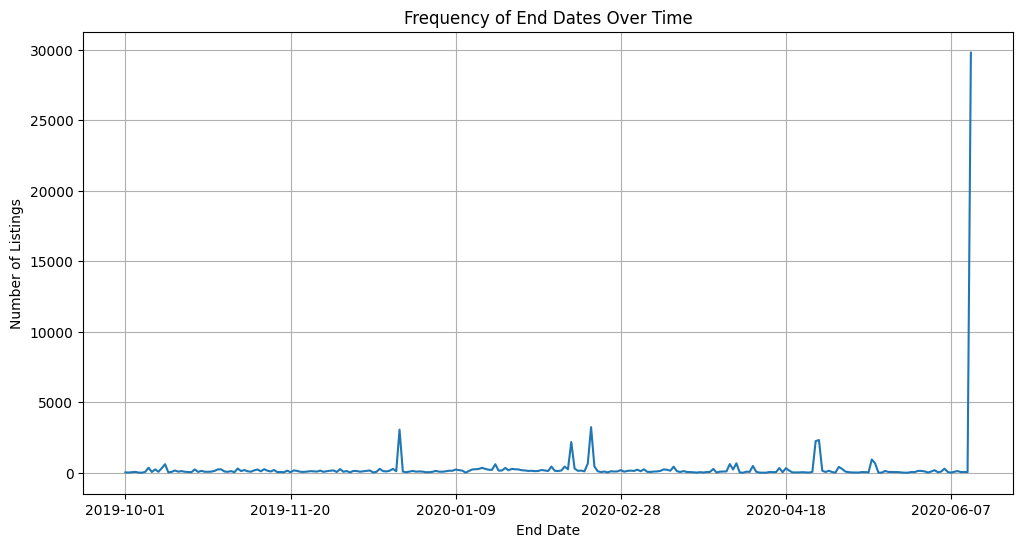

In [ ]:
dtype = df["end_date"].dtype
row_count = df["end_date"].count()
null_count = df["end_date"].isnull().sum()
unique = df["end_date"].unique()

print("Variable: end_date")
print(f"Tipo de dato: {dtype}")
print(f"Registros con datos: {row_count}")
print(f"Registros nulos: {null_count}")

end_date_counts = df['end_date'].value_counts().sort_index()

# Visualizamos la distribución temporal
plt.figure(figsize=(12, 6))
end_date_counts.plot()
plt.title('Frecuencia de Fechas de Finalización a lo Largo del Tiempo')
plt.xlabel('Fecha de Finalización')
plt.ylabel('Número de Anuncios')
plt.grid(True)
plt.show()

### created_on - Fecha en la que se creo el anuncio de la propiedad

**Conclusión:** Es redundante con start_date (verificamos que todos los valores coinciden), por lo que podemos eliminarla.

In [115]:
# Printeamos cantidad de registros cuya start_date sea distinta de created_on
print(df.loc[df["created_on"] != df["start_date"]]["created_on"].count())

0


### l1 - Pais donde esta ubicada la propiedad

**Conclusión:** La información geográfica del país podría ser relevante para el modelo, ya que el valor de las propiedades varía significativamente según el país.

Variable: l1
Tipo de dato: object
Row count: 76984
Null count: 0
Valores únicos
['Argentina' 'Uruguay' 'Estados Unidos' 'Brasil']


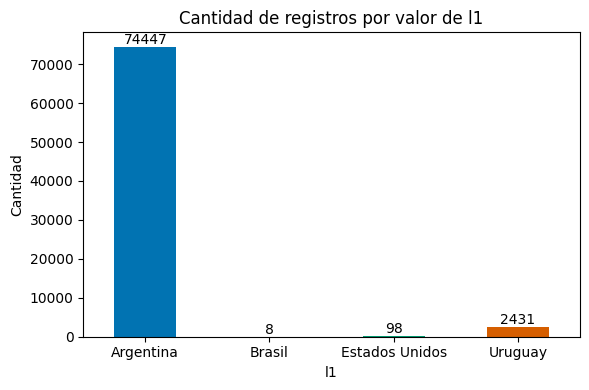

In [116]:
dtype = df["l1"].dtype
row_count = df["l1"].count()
null_count = df["l1"].isnull().sum()
unique = df["l1"].unique()

print("Variable: l1")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print("Valores únicos")
print(unique)

counts_l1 = df['l1'].value_counts().sort_index()
palette_l1 = sns.color_palette("colorblind", n_colors=len(counts_l1))

fig, ax = plt.subplots(figsize=(6, 4))
counts_l1.plot(kind='bar', ax=ax, color=palette_l1)
ax.set_title("Cantidad de registros por valor de l1")
ax.set_xlabel('l1')
ax.set_ylabel('Cantidad')
ax.tick_params(axis='x', rotation=0)
ax.bar_label(ax.containers[0], fmt='%d')
plt.tight_layout()
plt.show()

### l2 - Provincia donde esta ubicada la propiedad

**Conclusión:** Para usar esta variable necesitaríamos aplicar one-hot encoding, pero con 31 valores únicos generaríamos 30 columnas adicionales. Esto podría generar demasiada dimensionalidad, por lo que exploraremos alternativas más adelante.

Variable: l2
Tipo de dato: object
Row count: 76984
Null count: 0
Valores únicos
31


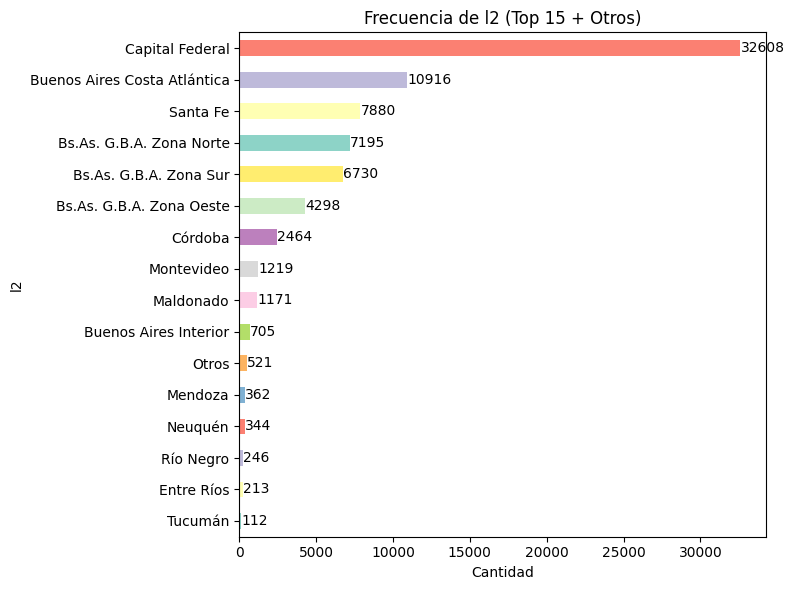

In [117]:
dtype = df["l2"].dtype
row_count = df["l2"].count()
null_count = df["l2"].isnull().sum()
unique = df["l2"].unique()

print("Variable: l2")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print("Valores únicos")
print(len(unique))

top_n = 15  # Veremos solo el top 15 de Región, Zona o Provincia (L2)
counts_l2 = df['l2'].value_counts()

top_counts = counts_l2.head(top_n)
other_count = counts_l2.iloc[top_n:].sum()
if other_count > 0:
    top_counts = pd.concat([top_counts, pd.Series({'Otros': other_count})])

colors = list(plt.cm.Set3.colors[:len(top_counts)])

fig, ax = plt.subplots(figsize=(8, 6))
top_counts.sort_values().plot(kind='barh', ax=ax, color=colors)
ax.set_title(f"Frecuencia de l2 (Top {top_n} + Otros)")
ax.set_xlabel('Cantidad')
ax.set_ylabel('l2')
ax.bar_label(ax.containers[0], fmt='%d')
plt.tight_layout()
plt.show()

### l3 - Partido donde se ubica la propiedad

**Conclusión:** Tiene 295 valores únicos, lo cual es demasiado para nuestro modelo. Aunque podría tener información útil similar a l1 y l2, su alta dimensionalidad hace difícil su uso práctico.

Variable: l3
Tipo de dato: object
Row count: 72486
Null count: 4498
Valores únicos: 295


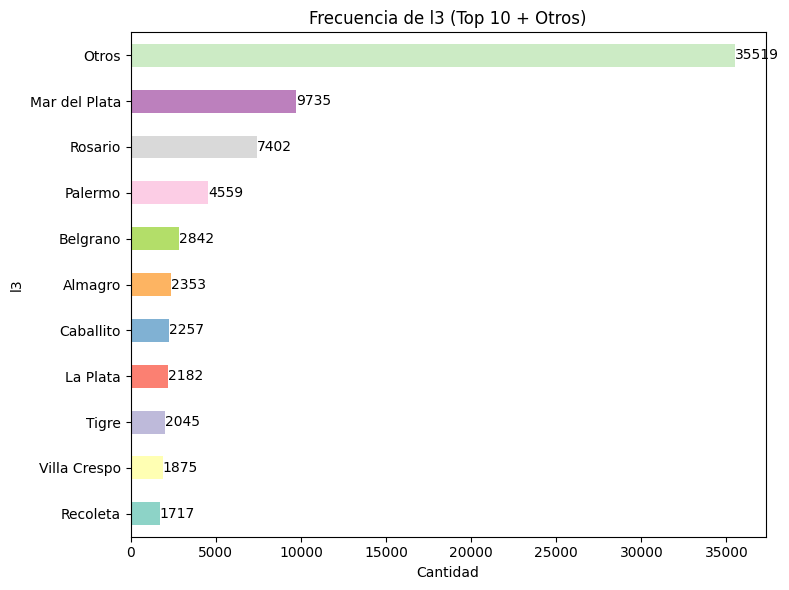

In [118]:
dtype = df["l3"].dtype
row_count = df["l3"].count()
null_count = df["l3"].isnull().sum()
unique_count = len(df["l3"].unique())

print("Variable: l3")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print(f"Valores únicos: {unique_count}")


top_n = 10 
counts_l3 = df['l3'].value_counts()

top_counts = counts_l3.head(top_n)
other_count = counts_l3.iloc[top_n:].sum()
if other_count > 0:
    top_counts = pd.concat([top_counts, pd.Series({'Otros': other_count})])

colors = list(plt.cm.Set3.colors[:len(top_counts)])

fig, ax = plt.subplots(figsize=(8, 6))
top_counts.sort_values().plot(kind='barh', ax=ax, color=colors)
ax.set_title(f"Frecuencia de l3 (Top {top_n} + Otros)")
ax.set_xlabel('Cantidad')
ax.set_ylabel('l3')
ax.bar_label(ax.containers[0], fmt='%d')
plt.tight_layout()
plt.show()

De los 295 valores que puede tomar la variable, 57 aparecen solo una vez.

In [119]:
l3_count = df.groupby('l3').size().reset_index(name='count')
print(l3_count.loc[l3_count["count"] < 2].count())

l3       57
count    57
dtype: int64


### l4, l5 y l6 - Ciudad/Barrio donde esta ubicada la propiedad

**Conclusión:** Estas variables tienen muy poca información (l4: ~19%, l5: ~0.2%, l6: 0%). No las utilizaremos por su escasa cobertura.

In [120]:
l4_row_count = df["l4"].count()
l5_row_count = df["l5"].count()
l6_row_count = df["l6"].count()

print(f"Conteo l4: {l4_row_count}")
print(f"Conteo l5: {l5_row_count}")
print(f"Conteo l6: {l6_row_count}")

Conteo l4: 14777
Conteo l5: 159
Conteo l6: 0


### lat y Lon - Latitud y Longitud

**Conclusión:** Las coordenadas geográficas proporcionan información similar a l1 y l2, y ambas tienen una cantidad considerable de nulos (~12%). Preferiremos trabajar con l1 y l2 por simplicidad.

In [121]:
dtype = df["lat"].dtype
row_count = df["lat"].count()
null_count = df["lat"].isnull().sum()
print("Variable: lat")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

print("\n")

dtype = df["lon"].dtype
row_count = df["lon"].count()
null_count = df["lon"].isnull().sum()
print("Variable: lon")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

Variable: lat
Tipo de dato: float64
Row count: 67643
Null count: 9341


Variable: lon
Tipo de dato: float64
Row count: 67498
Null count: 9486


### rooms - Cantidad de habitaciones de la propiedad

**Conclusión:** Variable con potencial predictivo significativo. Tiene ~22% de nulos que deberemos imputar.

In [122]:
dtype = df["rooms"].dtype
row_count = df["rooms"].count()
null_count = df["rooms"].isnull().sum()

print("Variable: rooms")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

Variable: rooms
Tipo de dato: float64
Row count: 59968
Null count: 17016


### bedrooms - Cantidad de dormitorios de la propiedad



**Conclusión:** Otra variable importante para predecir el precio. Sin embargo, tiene ~50% de valores nulos, lo que representa un desafío considerable.

In [123]:
dtype = df["bedrooms"].dtype
row_count = df["bedrooms"].count()
null_count = df["bedrooms"].isnull().sum()

print("Variable: bedrooms")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")



Variable: bedrooms
Tipo de dato: float64
Row count: 38049
Null count: 38935


### bathrooms - Cantidad de baños de la propiedad

**Conclusión:** Variable relevante con solo ~7% de nulos, lo cual es manejable. Definitivamente la incluiremos en el modelo.

In [124]:
dtype = df["bathrooms"].dtype
row_count = df["bathrooms"].count()
null_count = df["bathrooms"].isnull().sum()

print("Variable: bathrooms")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

Variable: bathrooms
Tipo de dato: float64
Row count: 71826
Null count: 5158


### surface_total - Superficie total de la propiedad (en metros cuadrados)

**Conclusión:** Variable crítica para el modelo. Tiene ~44% de nulos, lo cual es bastante alto pero intentaremos imputarlos de forma inteligente.

In [125]:
dtype = df["surface_total"].dtype
row_count = df["surface_total"].count()
null_count = df["surface_total"].isnull().sum()

print("Variable: surface_total")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

# Es un float64, tiene valores decimales?
valores_no_nulos = df["surface_total"].dropna()
cantidad_decimales = (valores_no_nulos % 1 != 0).sum()
print(f"Cantidad de registros con decimales: {cantidad_decimales}")

Variable: surface_total
Tipo de dato: float64
Row count: 43049
Null count: 33935
Cantidad de registros con decimales: 0


### surface_covered - Superficie total cubierta de la propiedad (en metros cuadrados)

**Conclusión:** Junto con surface_total, es una de las variables más importantes. También tiene ~41% de nulos que necesitaremos imputar.

In [126]:
dtype = df["surface_covered"].dtype
row_count = df["surface_covered"].count()
null_count = df["surface_covered"].isnull().sum()

print("Variable: surface_covered")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

# Es un float64, tiene valores decimales?
valores_no_nulos = df["surface_covered"].dropna()
cantidad_decimales = (valores_no_nulos % 1 != 0).sum()
print(f"Cantidad de registros con decimales: {cantidad_decimales}")

Variable: surface_covered
Tipo de dato: float64
Row count: 45717
Null count: 31267
Cantidad de registros con decimales: 0


### price_period - Periodo en el que se cobrara el precio del anuncio

**Conclusión:** Solo tiene dos valores posibles: 'Mensual' o nulo. Con ~67% de nulos y poca variabilidad, esta variable no será útil.

In [127]:
dtype = df["price_period"].dtype
row_count = df["price_period"].count()
null_count = df["price_period"].isnull().sum()

print("Variable: price_period")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print(df["price_period"].unique())

Variable: price_period
Tipo de dato: object
Row count: 25755
Null count: 51229
[nan 'Mensual']


### title - Titulo del anuncio de la propiedad

Conclusion - No pareciera tener ningun valor predictivo.

In [128]:
dtype = df["title"].dtype
row_count = df["title"].count()
null_count = df["title"].isnull().sum()

print("Variable: title")
print(f"Tipo de dato: {dtype}")
print(f"Registros con datos: {row_count}")
print(f"Registros nulos: {null_count}")
print(df["title"].unique())

Variable: price_period
Tipo de dato: object
Row count: 76984
Null count: 0
['Venta depto dos ambientes con frente abierto'
 'VENTA 4 AMBIENTES C COCHERA FIJA MUY LUMINOSO'
 'Monoambiente con entrepiso-A 150 mts de Av- Shaw-' ...
 'Alsina  800 - U$D 95.000 - Departamento en Venta'
 'VENTA DEPARTAMENTO+LOFT 4 AMBIENTE EN MUÑIZ'
 'RETASADO!!! VENTA 3 AMB Exclusiva zona La Imprenta &amp; Cañitas-Frente-Balcón-Cochera ']


## Variable Target

La clase paga, representa un poco mas de un 11% del total de nuestros datos.  
La diferencia de proporciones no es suficiente como para considerar que las clases estan desbalanceadas.

In [129]:
# ¿Oversampling? ¿Undersampling?

pagan = df.loc[df["paga_comision"] == "paga"]["paga_comision"].count()
no_pagan = df.loc[df["paga_comision"] == "no paga"]["paga_comision"].count()
print(f"Paga: {pagan}")
print(f"No Paga: {no_pagan}")

Paga: 8772
No Paga: 68212


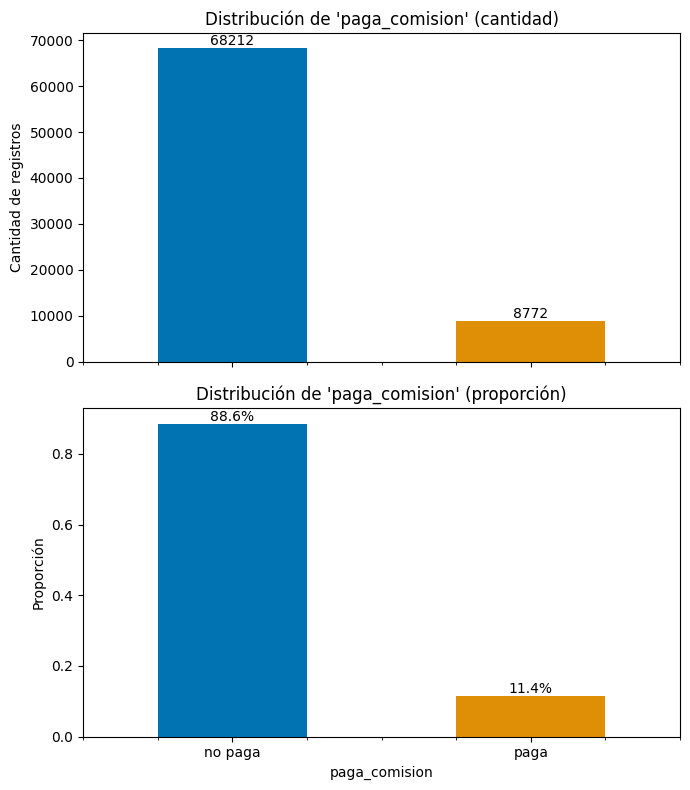

In [130]:
counts = df['paga_comision'].value_counts()
props = df['paga_comision'].value_counts(normalize=True)
palette = sns.color_palette("colorblind", n_colors=2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

counts.plot(kind='bar', ax=ax1, color=palette)
ax1.set_title("Distribución de 'paga_comision' (cantidad)")
ax1.set_ylabel('Cantidad de registros')
ax1.tick_params(axis='x', rotation=0)
ax1.bar_label(ax1.containers[0], fmt='%d')

props.plot(kind='bar', ax=ax2, color=palette)
ax2.set_title("Distribución de 'paga_comision' (proporción)")
ax2.set_xlabel('paga_comision')
ax2.set_ylabel('Proporción')
ax2.tick_params(axis='x', rotation=0)
ax2.bar_label(ax2.containers[0], fmt='{:.1%}')

plt.tight_layout()
plt.show()

In [131]:
print(df.columns)

Index(['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
       'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price_period', 'title',
       'paga_comision'],
      dtype='object')


## Analisis de nulos

In [132]:
variables_a_analizar_nulos = ['l1', 'l2', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

In [133]:
df[variables_a_analizar_nulos].isnull().sum()

l1                     0
l2                     0
rooms              17016
bedrooms           38935
bathrooms           5158
surface_total      33935
surface_covered    31267
dtype: int64

Conclusion - Algunas columnas tienen gran cantidad de nulos.  
Intentaremos imputarlos con el método más sencillo posible (media o mediana), si eso no no da buenos resultados, intentaremos algún método más complejo.

## Analisis de Outliers

In [ ]:
def analizar_outliers(col):
    """Analiza outliers usando IQR y genera visualización"""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)][col]
    print(f"Outliers detectados en {col} (IQR): {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)\nLimite inferior: {limite_inferior}\nLimite Superior: {limite_superior}")
    
    df[[col]].boxplot()
    plt.show()

In [135]:
variables_a_analizar_outliers = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

Outliers detectados en rooms (IQR): 2604 (3.38%)
Limite inferior: 0.5
Limite Superior: 4.5


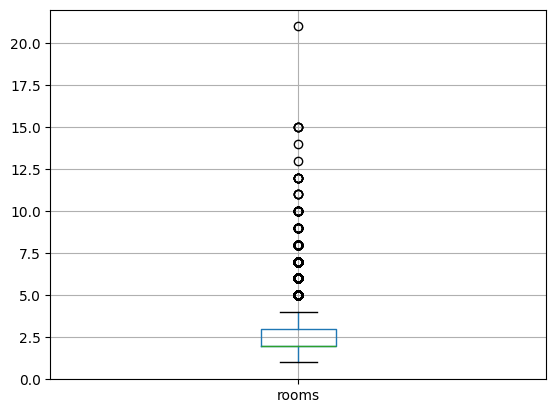

Outliers detectados en bedrooms (IQR): 1000 (1.30%)
Limite inferior: -0.5
Limite Superior: 3.5


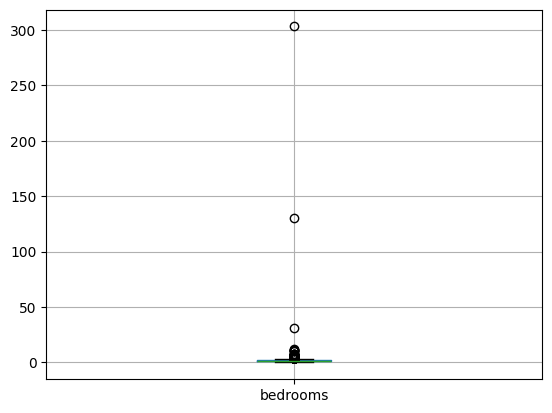

Outliers detectados en bathrooms (IQR): 1314 (1.71%)
Limite inferior: -0.5
Limite Superior: 3.5


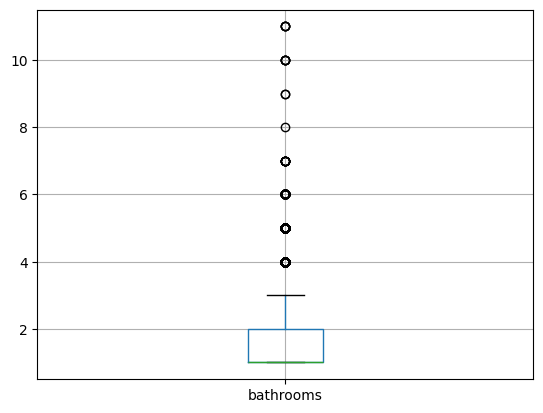

Outliers detectados en surface_total (IQR): 3114 (4.04%)
Limite inferior: -26.0
Limite Superior: 158.0


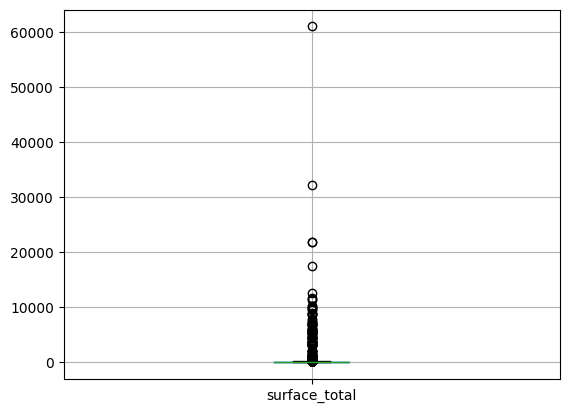

Outliers detectados en surface_covered (IQR): 3098 (4.02%)
Limite inferior: -17.0
Limite Superior: 135.0


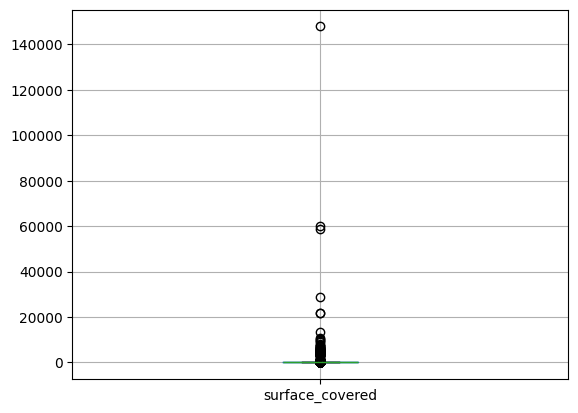

In [136]:
for col in variables_a_analizar_outliers:
    analizar_outliers(col)

### Outliers en Rooms

Podemos observar que, si bien hay datos erroneos, tambien hay muchos datos reales que estan siendo catalogados como outliers.

In [137]:
df.loc[df['rooms'] == 10].head(5)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_period,title,paga_comision
id,,,,,,,,,,,,,,,,,,,,
4rde5VlAeQ7MxFFPqH39Iw==,Propiedad,2020-01-27,9999-12-31,2020-01-27,-32.947895,-60.631504,Argentina,Santa Fe,Rosario,NaN,NaN,NaN,10.0,4.0,2.0,177.0,177.0,NaN,CORDOBA AL 600 | DEPARTAMENTO DE CATEGORIA FRE...,paga
tgAtwrgLw8SHKEV5ICgIeg==,Propiedad,2019-07-03,9999-12-31,2019-07-03,-34.914002,-57.958651,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,NaN,NaN,NaN,10.0,NaN,2.0,220.0,200.0,Mensual,Departamento - La Plata,paga
uuXc2R/EDq1oEQcniBNKYg==,Propiedad,2019-06-25,9999-12-31,2019-06-25,-34.608618,-58.394819,Argentina,Capital Federal,Congreso,NaN,NaN,NaN,10.0,NaN,10.0,850.0,NaN,Mensual,HOTEL BOUTIQUE SPA AMENITIES 10 HABITACIONES ...,paga
GURXyL/amBbxN9y6K5euDw==,Propiedad,2019-12-17,2020-03-19,2019-12-17,-31.418453,-64.184992,Argentina,Capital Federal,NaN,NaN,NaN,NaN,10.0,3.0,3.0,NaN,NaN,NaN,SE VENDE PISO 3 DORMITORIOS A METROS DEL PATIO...,no paga
1Z+WElJxFb6Eq5yjhdLB1w==,Propiedad,2019-05-18,9999-12-31,2019-05-18,-32.938209,-60.647568,Argentina,Santa Fe,Rosario,NaN,NaN,NaN,10.0,NaN,3.0,203.0,176.0,Mensual,Departamento - Centro,paga


### Eliminamos outliers

Vamos a eliminar outliers usando un factor de 2.25 y ver los resultados

In [138]:
df_original = df.copy()

for columna in variables_a_analizar_outliers:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 2.25 * IQR
    limite_superior = Q3 + 2.25 * IQR
    
    df = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

print(f"Filas eliminadas: {len(df_original) - len(df)}")
print(f"Filas restantes: {len(df)}")

Filas eliminadas: 57022
Filas restantes: 19962


Outliers detectados en rooms (IQR): 471 (2.36%)
Limite inferior: 0.5
Limite Superior: 4.5


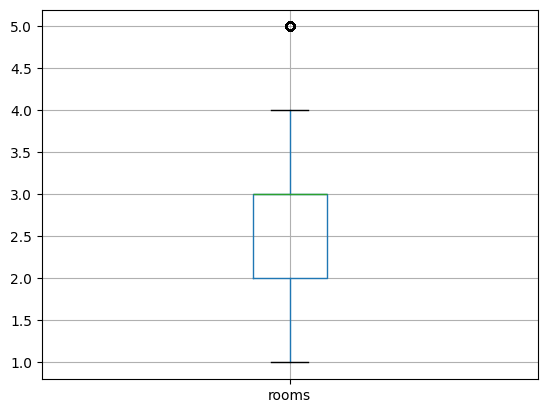

Outliers detectados en bedrooms (IQR): 210 (1.05%)
Limite inferior: -0.5
Limite Superior: 3.5


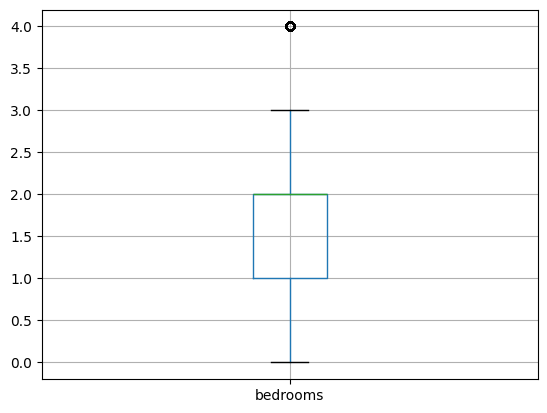

Outliers detectados en bathrooms (IQR): 119 (0.60%)
Limite inferior: -0.5
Limite Superior: 3.5


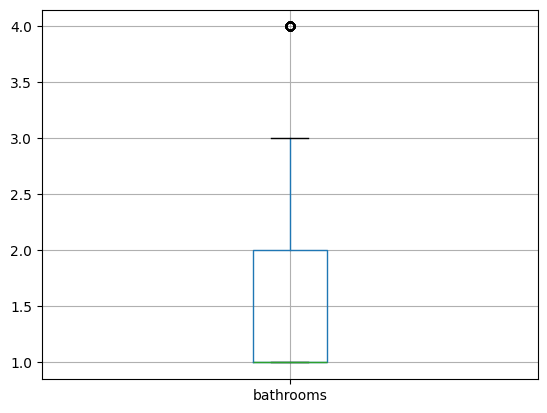

Outliers detectados en surface_total (IQR): 677 (3.39%)
Limite inferior: -14.0
Limite Superior: 146.0


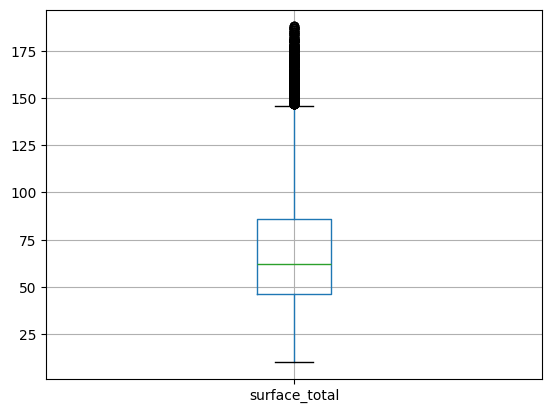

Outliers detectados en surface_covered (IQR): 671 (3.36%)
Limite inferior: -9.0
Limite Superior: 127.0


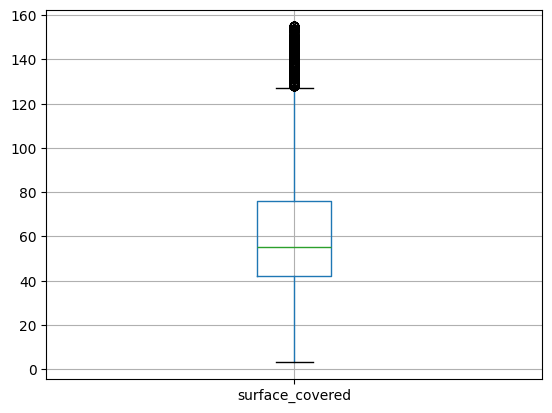

In [139]:
for col in variables_a_analizar_outliers:
    analizar_outliers(col)

Conclusion:  
El dataset original tiene muchos outliers y no es tarea fácil determinar cuantos son reales y cuantos son errores.  
Por ahora, eliminamos los outliers usando un factor de 2.25.  
Nuestra hipotesis es que, si bien estamos eliminando muchos valores reales al hacer esto, estamos dejando máximos lo suficientemente altos como para que nuestro modelo entienda que a mayor superficie o cantidad de cuartos aumenta la probabilidad de que la casa supere el precio requerido para cobrar comisión.

## Analisis Multivariado

Se procede a realizar el analisis multivariable de los datos para buscar correlaciones existentes entre los mismos

### Matriz de Correlacion

In [141]:
variables_matriz_correlacion = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

Como era de esperarse, la correlacion entre las variables de superficie y las de los diferentes tipos de cuartos en la propiedad poseen una alta correlacion entre ellas.  
Ademas, podemos observar que entre superficie y cuartos la correlacion es muy pequeña.

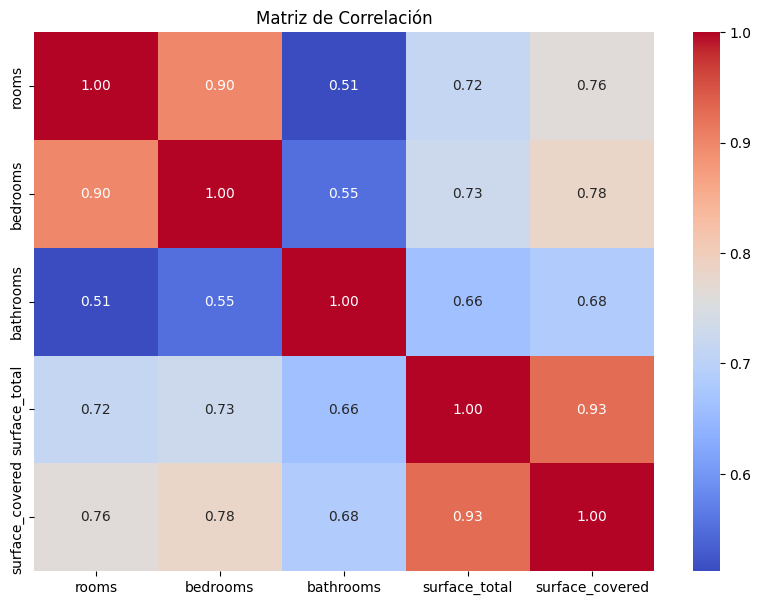

In [142]:
fig, ax = plt.subplots(figsize=(10,7))
mat = df[variables_matriz_correlacion].corr()
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

In [143]:
# Crear una versión numérica de paga_comision
df['paga_comision_numeric'] = (df['paga_comision'] == 'paga').astype(int)

# Ahora calcular correlaciones
df_corr = df[variables_matriz_correlacion + ['paga_comision_numeric']].corr()[["paga_comision_numeric"]] * 100

df_corr = df_corr.drop("paga_comision_numeric", axis=0)
df_corr = abs(df_corr)
df_corr = df_corr.sort_values(["paga_comision_numeric"], ascending=False)
df_corr

,paga_comision_numeric
surface_covered,58.756536
surface_total,57.341178
bathrooms,52.875804
bedrooms,36.444422
rooms,33.817098


Podemos ver que las variables surface_covered, surface_total y bathrooms son muy buenas predictoras de la variable target. bedrooms y rooms no se quedan atras.

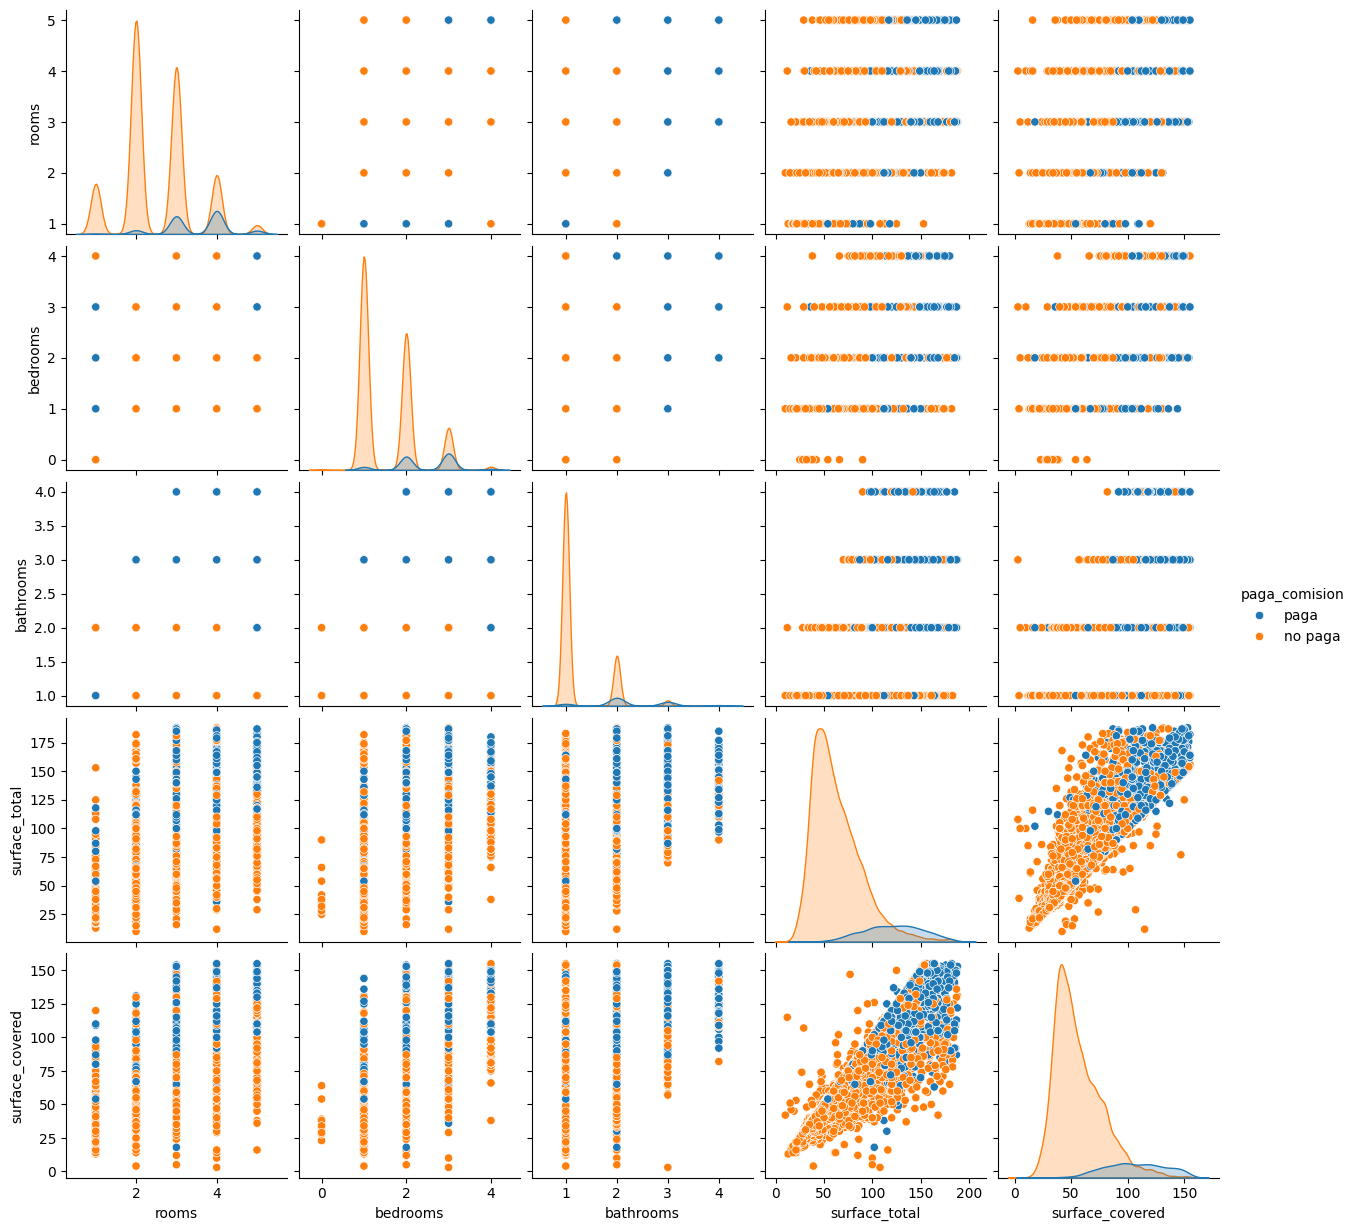

In [144]:
sns.pairplot(df[variables_matriz_correlacion + ['paga_comision']],hue="paga_comision")

### ¿Qué hacemos con l2?

¿Habrá relación entre la zona a la que pertenece una casa y si debe pagar comisión?  
Para responder, podemos plantear otra pregunta: ¿Para una misma superficie en 2 zonas distintas, la probabilidad de que esa casa pague comisión varía?

In [145]:
df['l2_average'] = df.groupby('l2')['surface_total'].transform('mean')

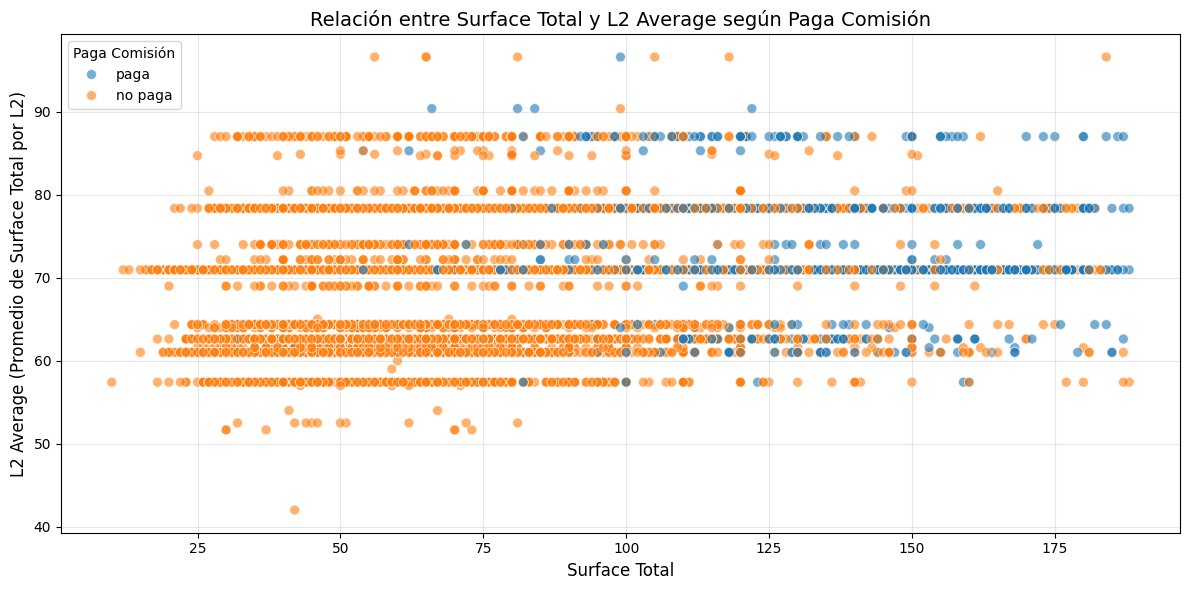

In [ ]:
# Gráfico de dispersión
plt.figure(figsize=(12, 6))

sns.scatterplot(data=df, x='surface_total', y='l2_average', 
                hue='paga_comision', alpha=0.6, s=50)

plt.xlabel('Superficie Total', fontsize=12)
plt.ylabel('Promedio L2 (Promedio de Superficie Total por L2)', fontsize=12)
plt.title('Relación entre Superficie Total y Promedio L2 según Paga Comisión', fontsize=14)
plt.legend(title='Paga Comisión')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Parecería que, para zonas con un promedio de superficie más alto, aumenta la proporcion de casas que paga comisión.

In [149]:
df['l2_avg_bin'] = pd.cut(df['l2_average'], bins=5)

resultado = df.groupby('l2_avg_bin', observed=True).agg({
    'paga_comision': [
        ('Total', 'count'),
        ('% Paga', lambda x: (x == 'paga').mean() * 100)
    ]
})

resultado.columns = ['Total Registros', '% Paga Comisión']
print(resultado.round(2))

df.drop('l2_avg_bin', axis=1, inplace=True)

                  Total Registros  % Paga Comisión
l2_avg_bin                                        
(41.945, 52.925]               17             0.00
(52.925, 63.85]              4014             3.31
(63.85, 74.775]             13385            12.81
(74.775, 85.7]               2242            14.09
(85.7, 96.625]                304            25.99


Conclusión: Podríamos usar la variable l2_average para entrenar a nuestro modelo y ver que resultados obtenemos.

# Conclusiones Finales:  
- Por ahora solo trabajaremos con la variable categorica l2, creando un promedio de surface_total por zona y luego descartandola.
- Todo valor que supere un factor de 2.25 será considerado outlier, esperamos que ese valor sea suficiente para que nuestro modelo aprenda que valores grandes aumentan la probabilidad de que una propiedad pague comisión.
- Tanto outliers como nulos serán imputados con la media de la variable en primera instancia, si eso no da los resultados esperados hilaremos mas fino.